In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, ops
import tensorflow_datasets as tfds
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
import shutil

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the Dataset

In [ ]:
os.makedirs("/content/Deep_Learning_coursework/face_image", exist_ok=True)
!unzip /content/drive/MyDrive/deep_learning/face_img.zip -d /content/Deep_Learning_coursework/face_image

os.makedirs("/content/Deep_Learning_coursework/face_image/celeb", exist_ok=True)
!unzip /content/Deep_Learning_coursework/face_image/face_align_celeba.zip -d /content/Deep_Learning_coursework/face_image/celeb

os.makedirs("/content/Deep_Learning_coursework/face_image/utk", exist_ok=True)
!unzip "/content/Deep_Learning_coursework/face_image/UTK Face Cropped.zip" -d /content/Deep_Learning_coursework/face_image/utk

os.makedirs("/content/Deep_Learning_coursework/cat_dog", exist_ok=True)
!unzip /content/drive/MyDrive/deep_learning/cat_and_dog-1.zip -d /content/Deep_Learning_coursework/cat_dog

os.makedirs("/content/Deep_Learning_coursework/cat_dog/dog_face", exist_ok=True)
!unzip "/content/Deep_Learning_coursework/cat_dog/dog faces.zip" -d /content/Deep_Learning_coursework/cat_dog/dog_face

os.makedirs("/content/Deep_Learning_coursework/cat_dog/cat_face", exist_ok=True)
!unzip /content/Deep_Learning_coursework/cat_dog/cat_face.zip -d /content/Deep_Learning_coursework/cat_dog/cat_face




Streaming output truncated to the last 5000 lines.
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24845.png  
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24846.png  
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24847.png  
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24848.png  
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24849.png  
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24850.png  
  inflating: /content/Deep_Learning_coursework/cat_dog/cat_face/Cat-faces-dataset-master/dataset-part3/dataset-part3/cat_24851.png  
  inflating: /cont

In [ ]:
# Define dataset paths
source_folders = [
    "/content/Deep_Learning_coursework/face_image/celeb",
    "/content/Deep_Learning_coursework/face_image/utk",
    "/content/Deep_Learning_coursework/cat_dog/cat_face",
    "/content/Deep_Learning_coursework/cat_dog/dog_face"
]

# Destination directory (for TensorFlow format)
organized_dataset = "/content/Deep_Learning_coursework/organized_dataset"
human_dest = os.path.join(organized_dataset, "humans")
animal_dest = os.path.join(organized_dataset, "animals")

# Ensure destination folders exist
os.makedirs(human_dest, exist_ok=True)
os.makedirs(animal_dest, exist_ok=True)

def move_images(source_dirs, class_name):
    dest_folder = os.path.join(organized_dataset, class_name)

    file_count = {}

    for source_dir in source_dirs:
        for root, _, files in os.walk(source_dir):
            for file in files:
                if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")):
                    source_path = os.path.join(root, file)
                    dest_path = os.path.join(dest_folder, file)

                    # Rename if duplicate
                    if os.path.exists(dest_path):
                        filename, ext = os.path.splitext(file)
                        file_count[filename] = file_count.get(filename, 0) + 1
                        new_filename = f"{filename}_{file_count[filename]}{ext}"
                        dest_path = os.path.join(dest_folder, new_filename)

                    shutil.move(source_path, dest_path)

# Move images into correctly labeled folders
move_images(["/content/Deep_Learning_coursework/face_image/celeb",
             "/content/Deep_Learning_coursework/face_image/utk"], "humans")

move_images(["/content/Deep_Learning_coursework/cat_dog/cat_face",
             "/content/Deep_Learning_coursework/cat_dog/dog_face"], "animals")


In [ ]:
# Paths to the human and animal face images
human_dir = '/content/Deep_Learning_coursework/organized_dataset/humans'
animal_dir = '/content/Deep_Learning_coursework/organized_dataset/animals'

# Common parameters for dataset loading
batch_size = 32
image_size = (256, 256)

# Load datasets
humans_ds = tf.keras.preprocessing.image_dataset_from_directory(
    human_dir, label_mode=None, image_size=image_size, batch_size=batch_size, shuffle=True, verbose=True
)
animals_ds = tf.keras.preprocessing.image_dataset_from_directory(
    animal_dir, label_mode=None, image_size=image_size, batch_size=batch_size, shuffle=True, verbose=True
)

train_humans = humans_ds.unbatch().take(10000)
train_animals = animals_ds.unbatch().take(10000)

test_humans = humans_ds.unbatch().take(100)
test_animals = animals_ds.unbatch().take(100)





Found 250017 files.
Found 48863 files.


In [ ]:
# Defining the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = ops.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resizing to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256x256
    # The size argument must include the number of channels
    img = tf.image.random_crop(img, size=input_img_size)
    # Normalizing the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img




def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = ops.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


## Create Dataset Objects

In [ ]:

# Applying the preprocessing operations to the training data
train_humans = (
    train_humans.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)

)
train_animals = (
    train_animals.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Applying the preprocessing operations to the test data
test_humans = (
    test_humans.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_animals = (
    test_animals.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)


In [ ]:
test_animals,train_animals

(<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 <_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

## Visualize some samples

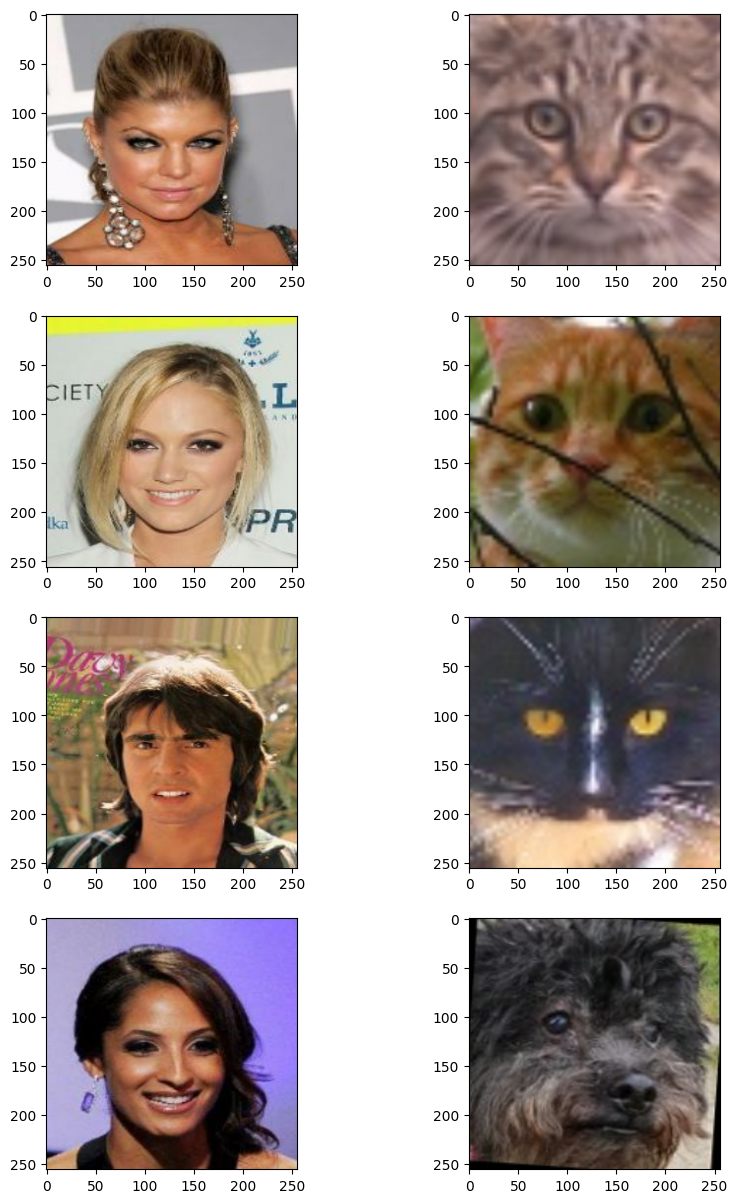

In [ ]:

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(test_humans.take(4), test_animals.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()


## Building blocks used in CycleGAN Generators and Discriminators

In [ ]:

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return ops.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    if activation:
        x = activation(x)
    return x


## Building the Generator

The generator consists of downsampling blocks: nine residual blocks and   
upsampling blocks. The structure of the generator is the following:  

c7s1-64 ==> Conv block with `relu` activation, filter size of 7  
d128 ====|  
         |-> 2 downsampling blocks  
d256 ====|  
R256 ====|  
R256     |  
R256     |  
R256     |  
R256     |-> 9 residual blocks  
R256     |  
R256     |  
R256     |  
R256 ====|  
u128 ====|  
           |-> 2 upsampling blocks  
u64  ====|  
c7s1-3 => Last conv block with `tanh` activation, filter size of 7.

In [ ]:

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


## Building the Discriminator

The discriminators implement the following architecture: C64->C128->C256->C512

In [ ]:

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


Building the Cycle GAN model

In [ ]:

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


Create a call back that periodically saves the generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_humans.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = np.clip(prediction, -1, 1)
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


Training End to End model

In [ ]:
os.makedirs("/content/drive/MyDrive/deep_learning/Task_1", exist_ok=True)

Epoch 1/10
  10000/Unknown 787s 69ms/step - D_X_loss: 0.1929 - D_Y_loss: 0.2046 - F_loss: 2.1831 - G_loss: 1.9623

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


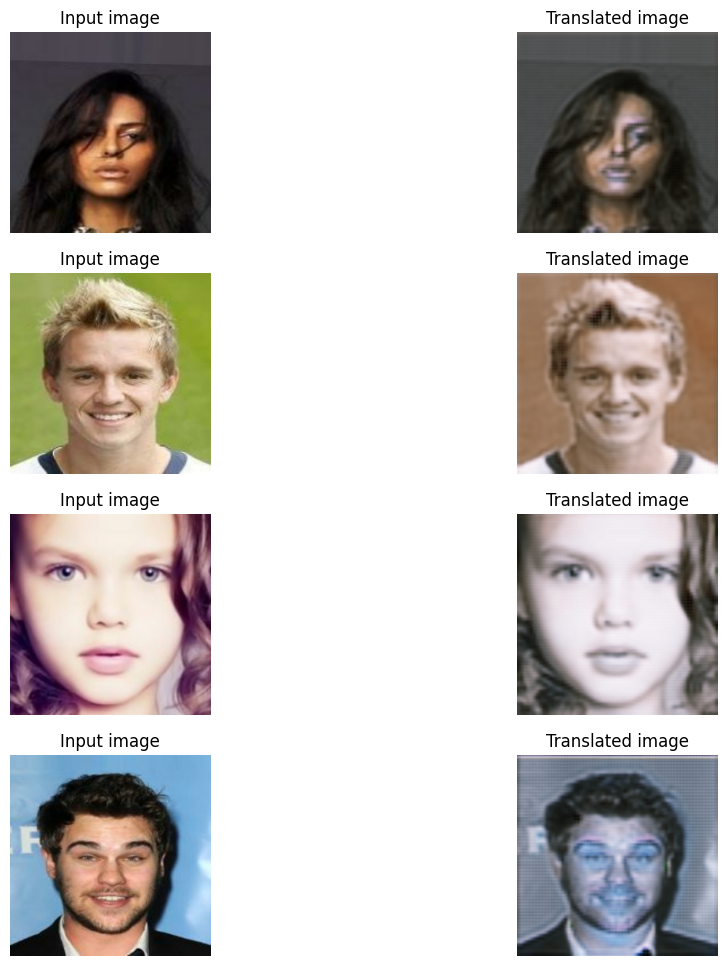

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 797s 70ms/step - D_X_loss: 0.1929 - D_Y_loss: 0.2046 - F_loss: 2.1831 - G_loss: 1.9623
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - D_X_loss: 0.1924 - D_Y_loss: 0.2193 - F_loss: 1.8133 - G_loss: 1.7401

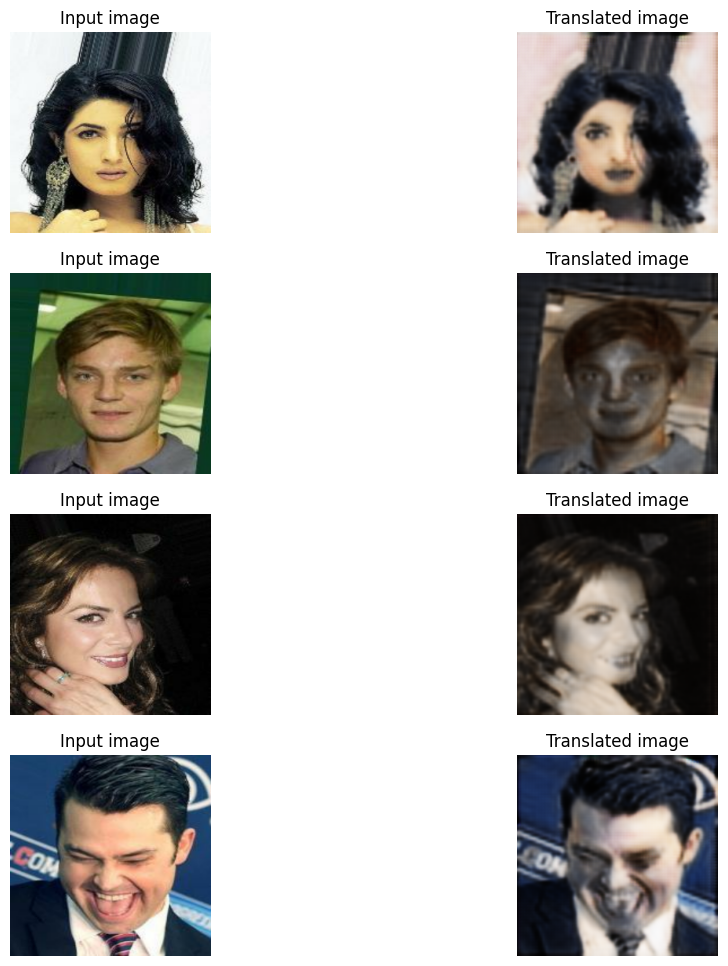

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 689s 69ms/step - D_X_loss: 0.1924 - D_Y_loss: 0.2193 - F_loss: 1.8133 - G_loss: 1.7402
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - D_X_loss: 0.1947 - D_Y_loss: 0.2342 - F_loss: 1.9774 - G_loss: 1.9606

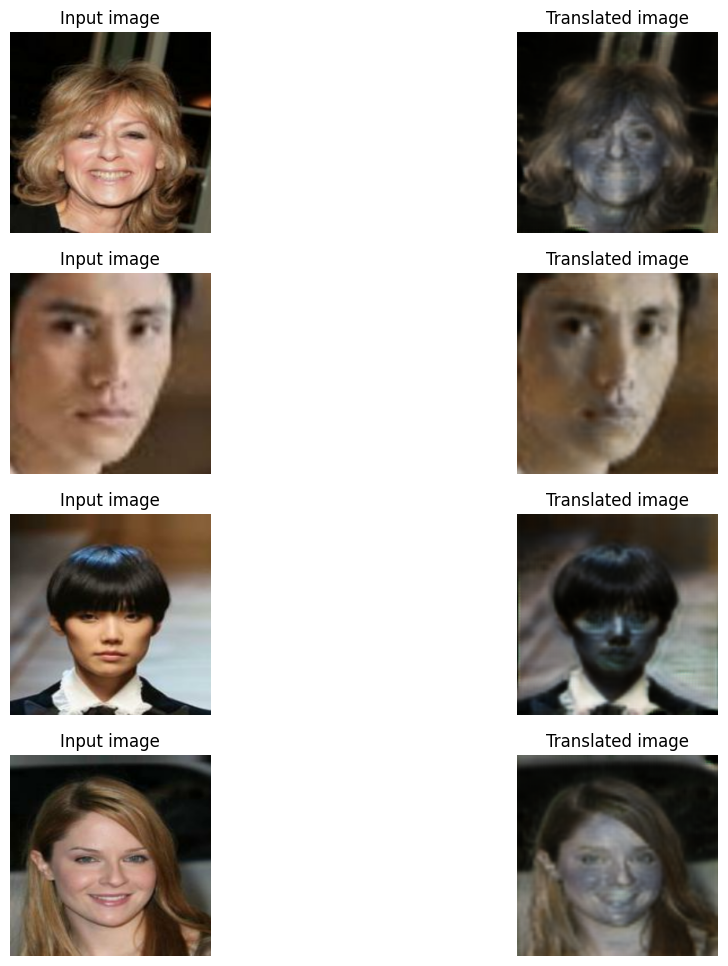

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 689s 69ms/step - D_X_loss: 0.1947 - D_Y_loss: 0.2342 - F_loss: 1.9775 - G_loss: 1.9606
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - D_X_loss: 0.1876 - D_Y_loss: 0.2312 - F_loss: 1.9990 - G_loss: 1.9439

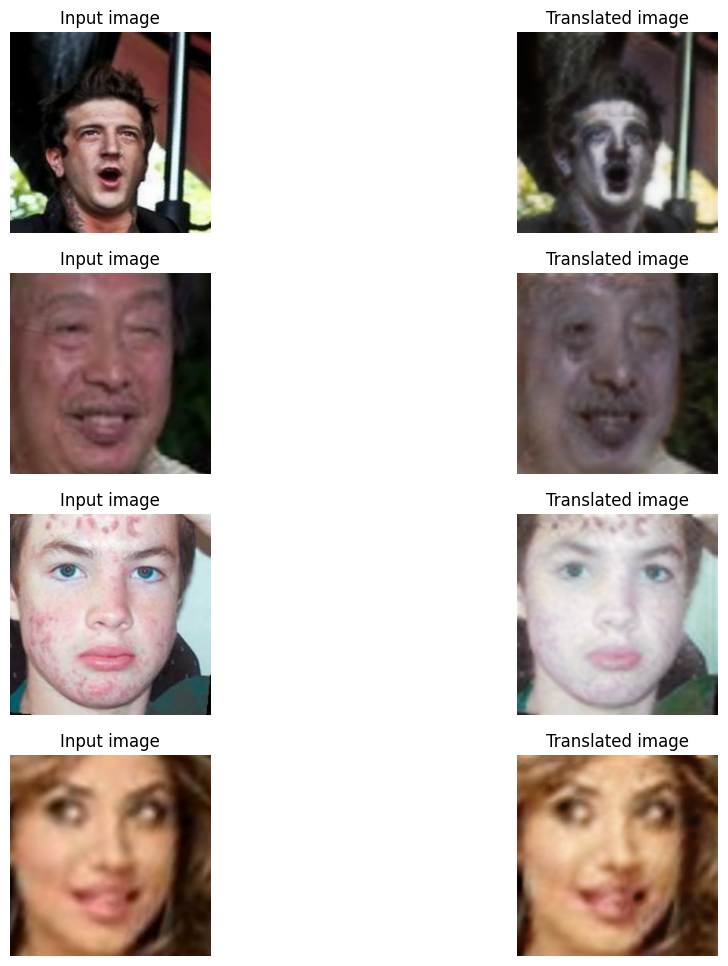

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 690s 69ms/step - D_X_loss: 0.1876 - D_Y_loss: 0.2312 - F_loss: 1.9990 - G_loss: 1.9439
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - D_X_loss: 0.1834 - D_Y_loss: 0.2079 - F_loss: 2.0016 - G_loss: 2.0811

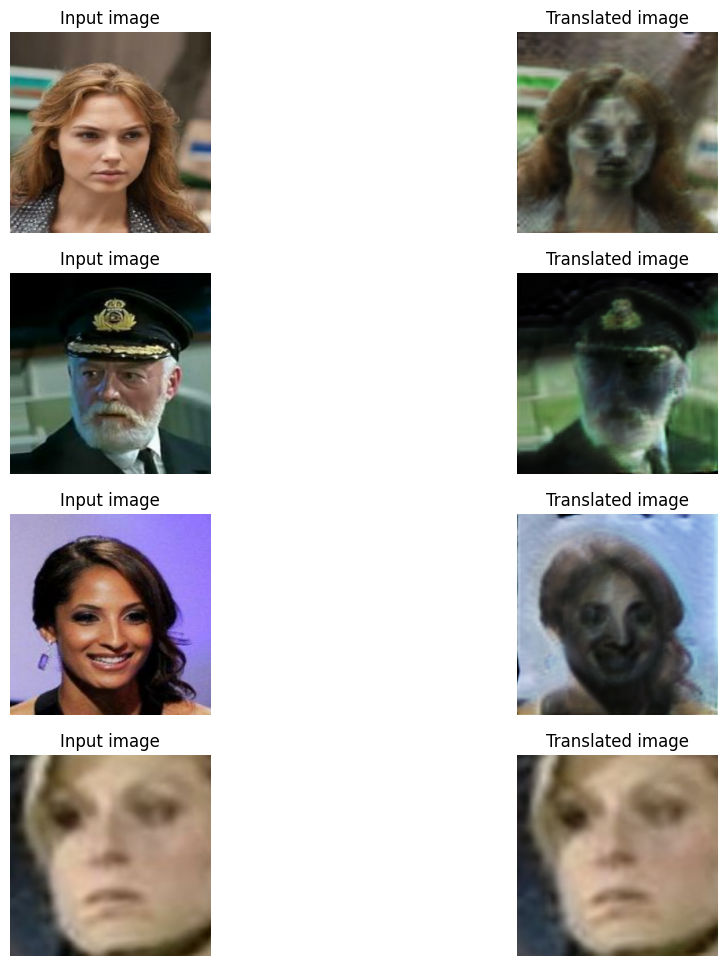

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 691s 69ms/step - D_X_loss: 0.1833 - D_Y_loss: 0.2079 - F_loss: 2.0017 - G_loss: 2.0812
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - D_X_loss: 0.1808 - D_Y_loss: 0.1779 - F_loss: 1.9084 - G_loss: 2.1861

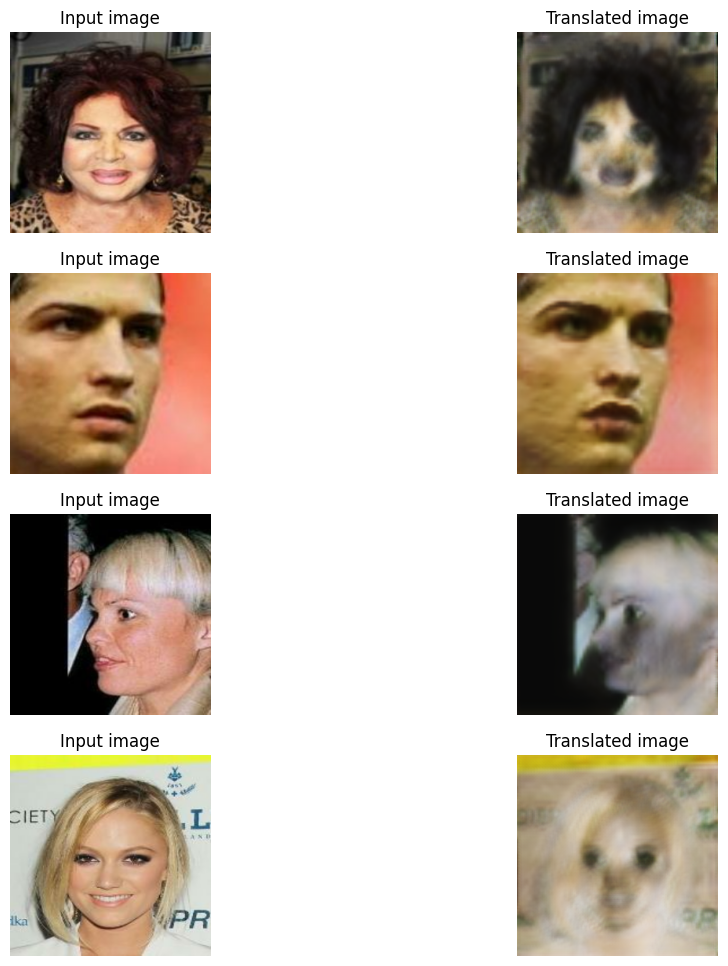

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 692s 69ms/step - D_X_loss: 0.1808 - D_Y_loss: 0.1780 - F_loss: 1.9084 - G_loss: 2.1862
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - D_X_loss: 0.1815 - D_Y_loss: 0.1754 - F_loss: 1.9238 - G_loss: 2.2149

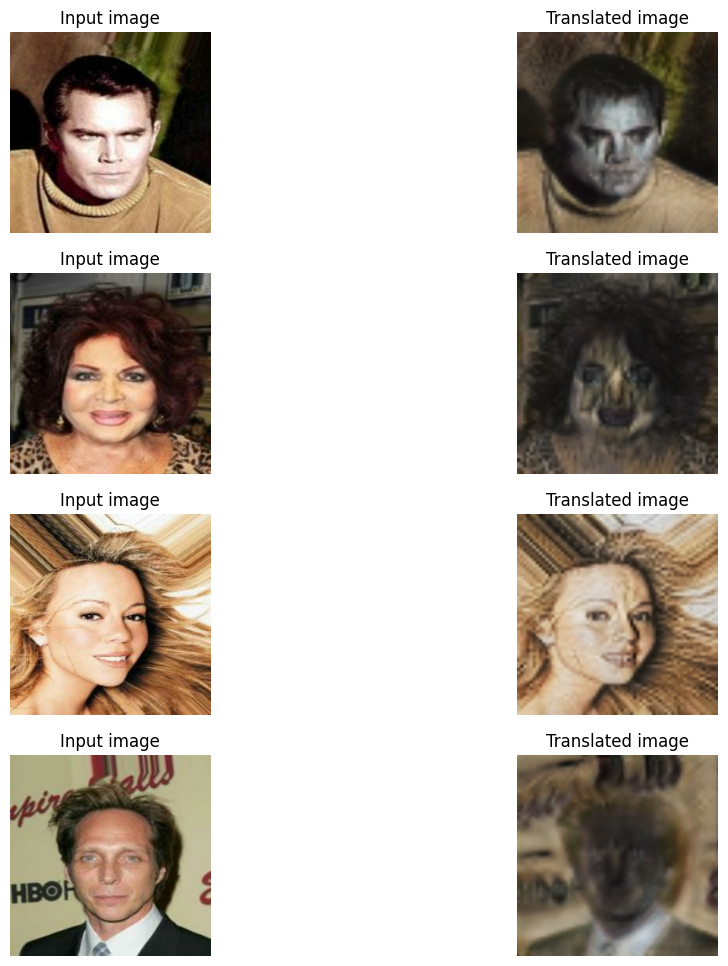

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 693s 69ms/step - D_X_loss: 0.1815 - D_Y_loss: 0.1754 - F_loss: 1.9239 - G_loss: 2.2149
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - D_X_loss: 0.1824 - D_Y_loss: 0.1579 - F_loss: 1.9222 - G_loss: 2.3025

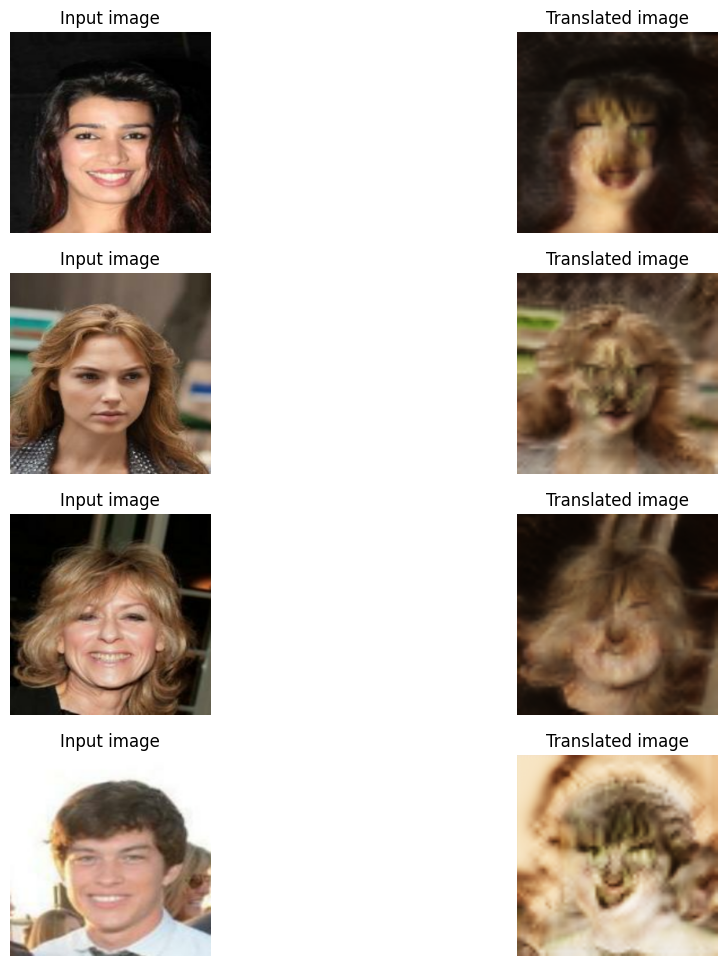

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 693s 69ms/step - D_X_loss: 0.1824 - D_Y_loss: 0.1579 - F_loss: 1.9221 - G_loss: 2.3026
Epoch 9/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - D_X_loss: 0.1819 - D_Y_loss: 0.1567 - F_loss: 1.9877 - G_loss: 2.3362

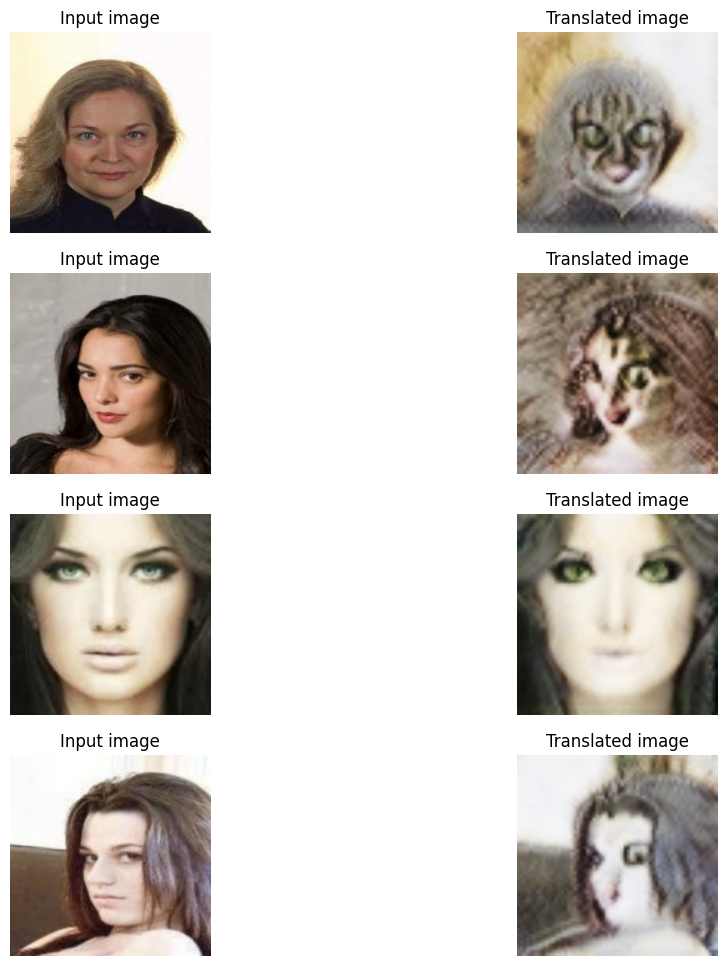

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 692s 69ms/step - D_X_loss: 0.1818 - D_Y_loss: 0.1567 - F_loss: 1.9877 - G_loss: 2.3361
Epoch 10/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - D_X_loss: 0.1784 - D_Y_loss: 0.1601 - F_loss: 1.9964 - G_loss: 2.3368

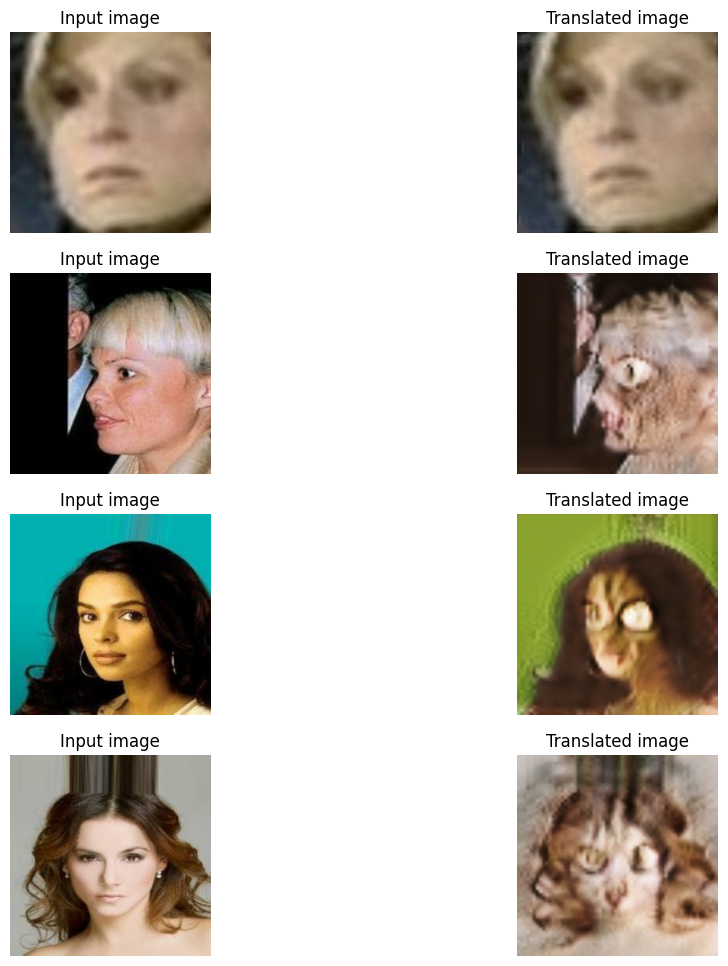

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 694s 69ms/step - D_X_loss: 0.1784 - D_Y_loss: 0.1601 - F_loss: 1.9965 - G_loss: 2.3368


In [ ]:

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators


def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(ops.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(ops.ones_like(real), real)
    fake_loss = adv_loss_fn(ops.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)


# Build the model by calling it with a sample input
# This ensures the model structure is finalized before saving weights
sample_input_shape = (1, *input_img_size)  # Assuming batch size of 1
sample_input = tf.zeros(sample_input_shape)
_ = cycle_gan_model(sample_input)

# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "/content/drive/MyDrive/deep_learning/Task_1/cyclegan_checkpoints.weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)



# save the model here

cycle_gan_model.fit(
    tf.data.Dataset.zip((train_humans, train_animals)),
    epochs=10,
    callbacks=[plotter, model_checkpoint_callback],
)

Testing the performance of the model

Weights loaded successfully


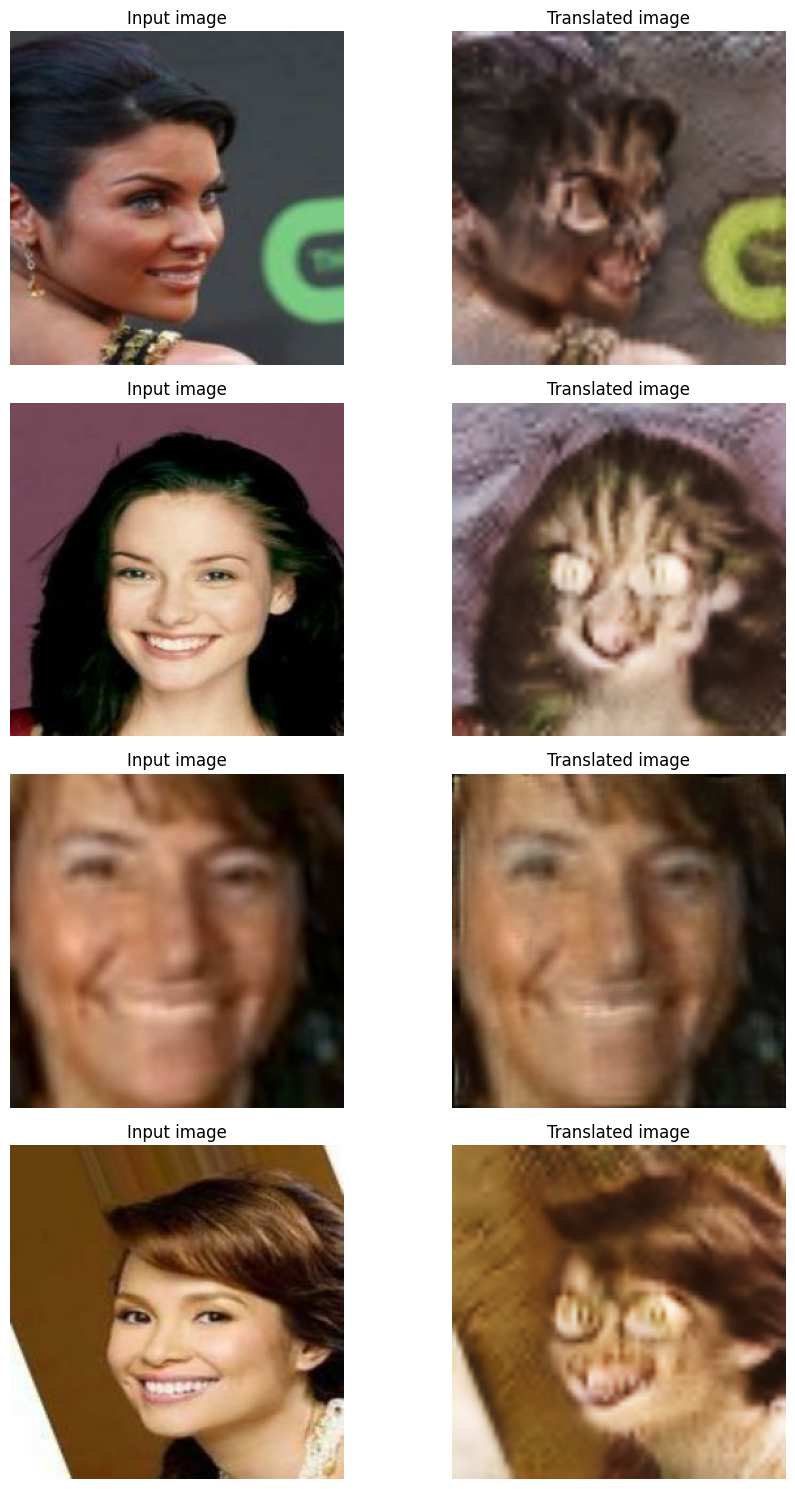

In [ ]:

# Once the weights are loaded, we will take a few samples from the test data and check the model's performance.
# Load the checkpoints
cycle_gan_model.load_weights(checkpoint_filepath)
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_humans.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = np.clip(prediction, -1, 1)
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()